# Seasonal variations
Plotting the timeseries of the variables is useful to get a general insight about the historical variation and multiyear trends, but as you may noticed, most variables have a strong seasonal (yearly) component. 
The function `plot_contents()` can be use plot the seasonal variations of each year.

In [1]:
from funciones import*
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import iceclassic as ice
file3=ice.import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/time_serie_data.txt')
Data=pd.read_csv(file3,skiprows=162,index_col=0,sep='\t')   
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Data = Data[Data.index.year < 2022]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 1:</b> 

Read the documentation for `plot_contents()` and plot the yearly variation of  `'Regional: Air temperature [C]'`and `'Gulkana Temperature [C]'`
</p>
</div>


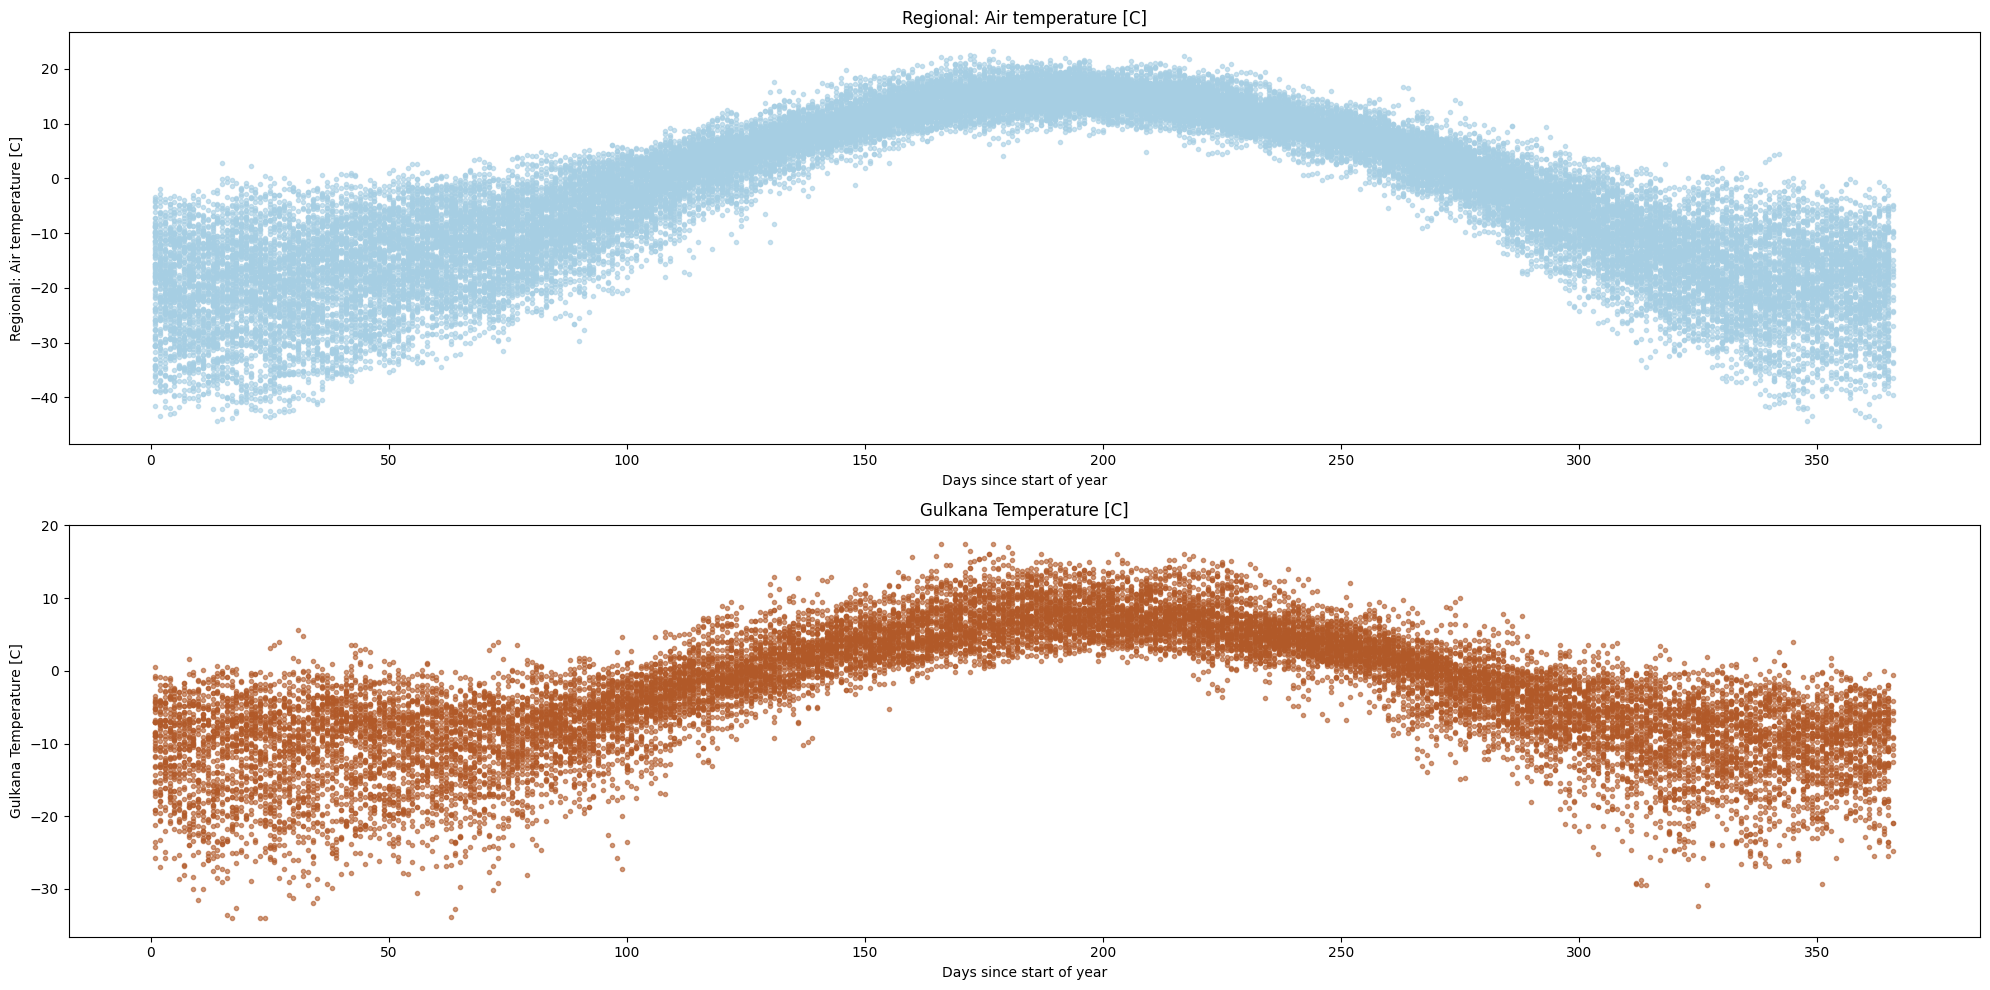

In [2]:
ice.plot_contents(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],col_cmap='Paired',scatter_alpha=0.6)

Using a scatter plot might not be the best idea as the figure can get cluttered,  even when we adjust the opacity/size of the markers.  
The figure becomes even less clear if we plot multiple variables/columns together. A simple alternative, is to plot the mean/standard deviation of each column, by passing the arguments `plot_together=True`, and `plot_mean_std='only`

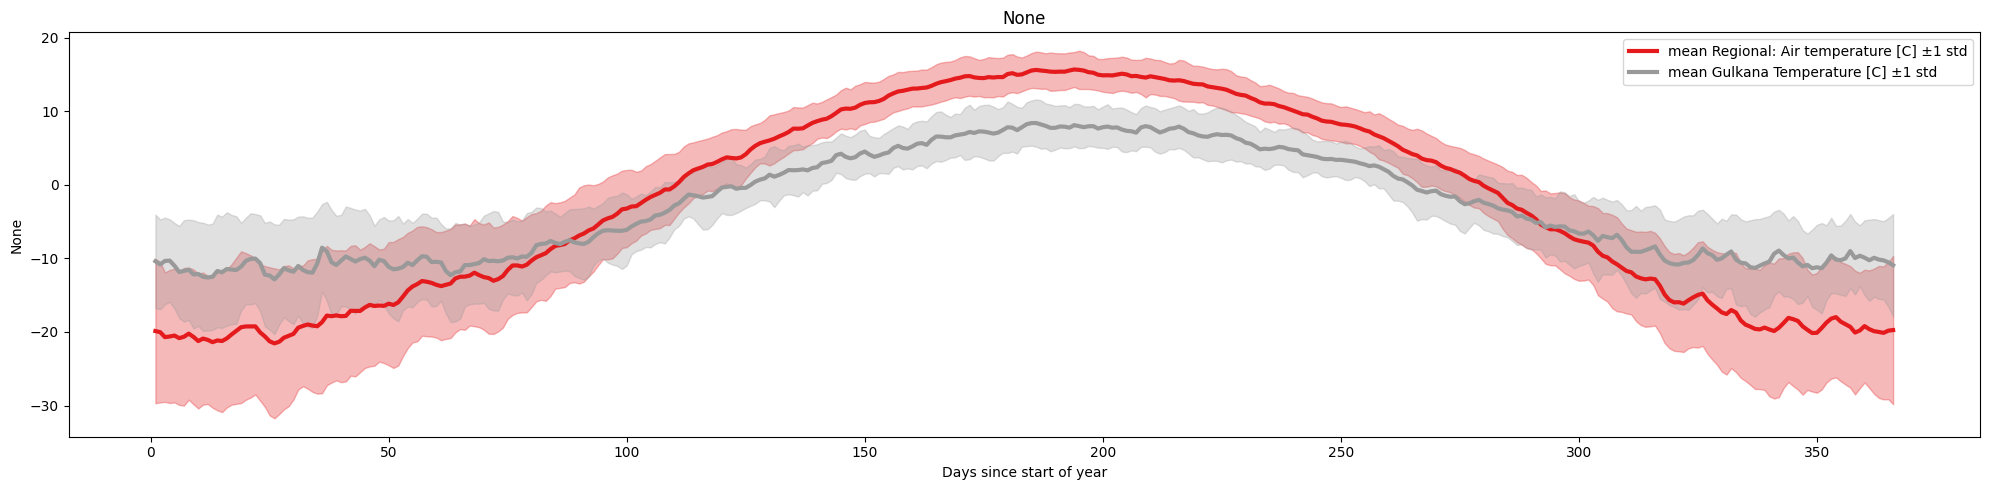

In [3]:
ice.plot_contents(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],plot_together=True,plot_mean_std='only',k=1)

Another useful feature of the function is the ability to use it to compare the behavior of a certain set of years to the baseline ( aggregated data for all years)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2:</b> 

Use  the argument  `multiyear`  to plot the data corresponding to the years 2009 and 2015 over the mean.
</p>
</div>


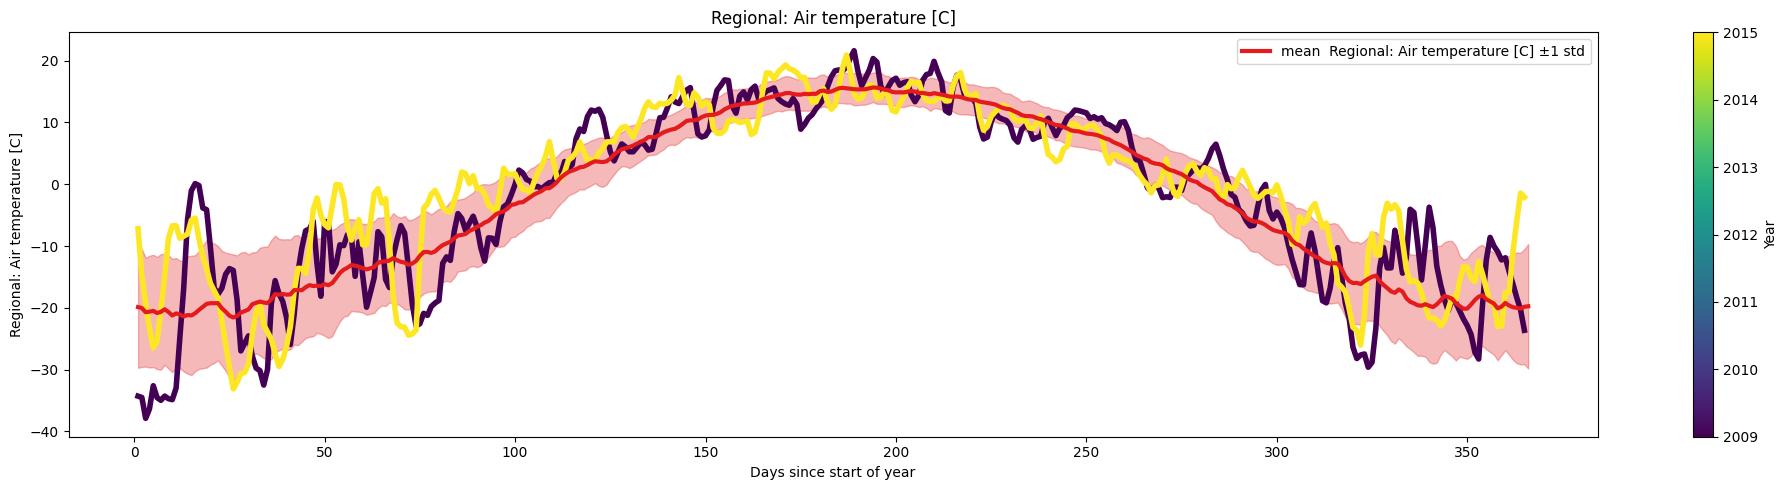

In [4]:
selected_years = [2009,2015]
ice.plot_contents(Data,k=1,plot_mean_std='only',multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'])

So far, we have used  the number of days since the start of the year as the x-axis, which is a natural, yet completely arbitrary. More likely,  another date or event/milestone is more meaningful, for example, choosing `xaxis='Days until break-up'` might be useful to observe trends leading up to the ice break-up, or , choosing `xaxis='index'` will recover the timeseries plot.

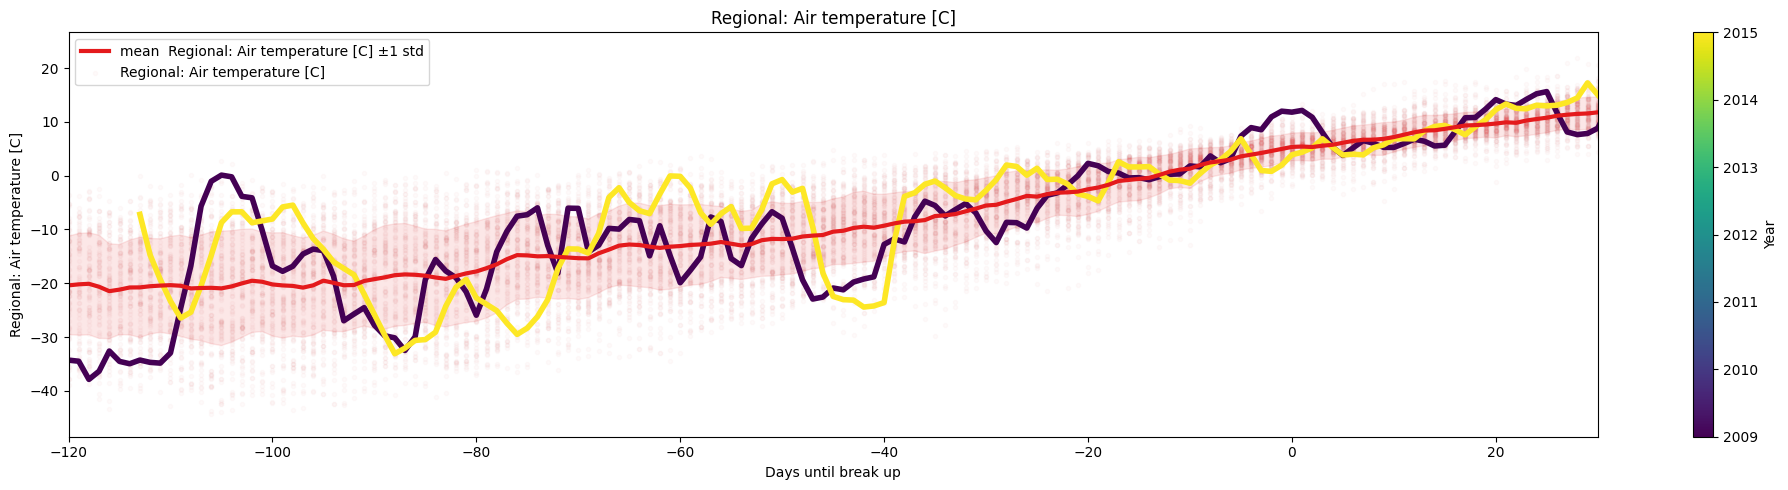

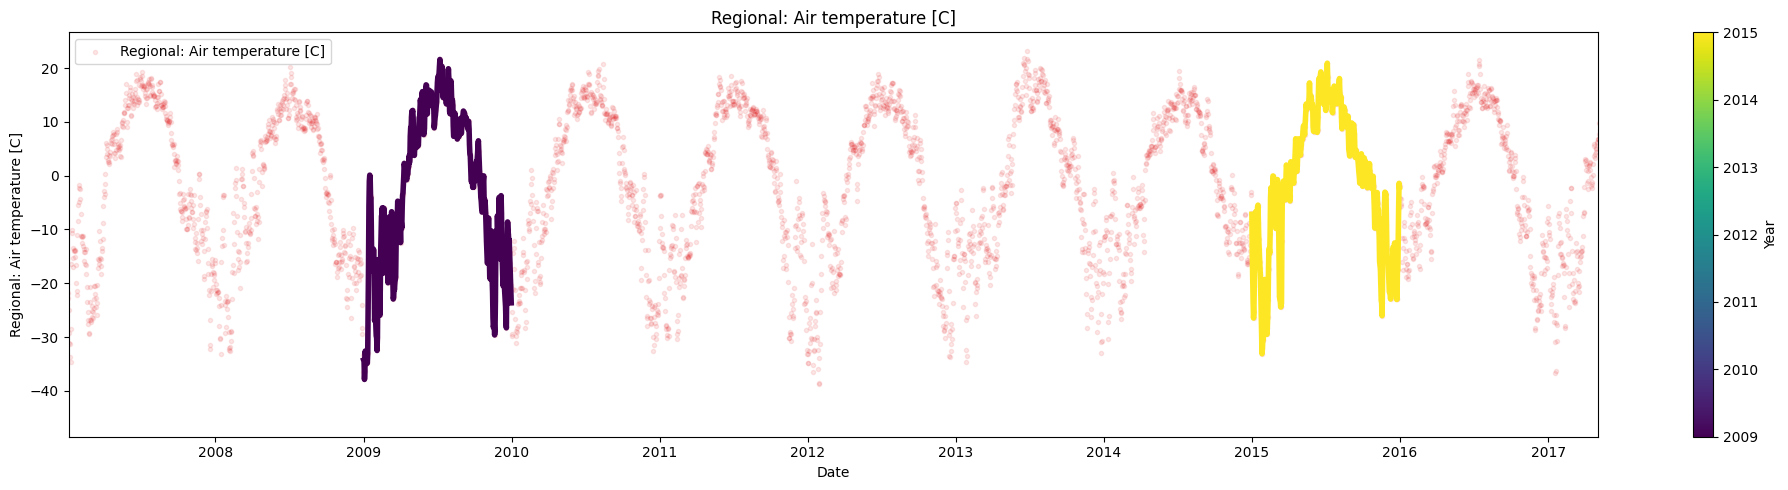

In [6]:
ice.plot_contents(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Days until break up',xlim=[-120,30],
              plot_mean_std='true',scatter_alpha=.02,std_alpha=.1) 

ice.plot_contents(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='index',xlim=['2007/01/04','2017/05/03']) 

If we want to use an 'x-axis' that is not a column in the original `DataFrame`, we have to create a new `DataFrame/Series`, merge it to the original `DataFrame` and then use the previous function.


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 3:</b> 

Use `days_since_last_date()` and `plot_contents()` to plot the temperature variation since the start of winter.
</p>


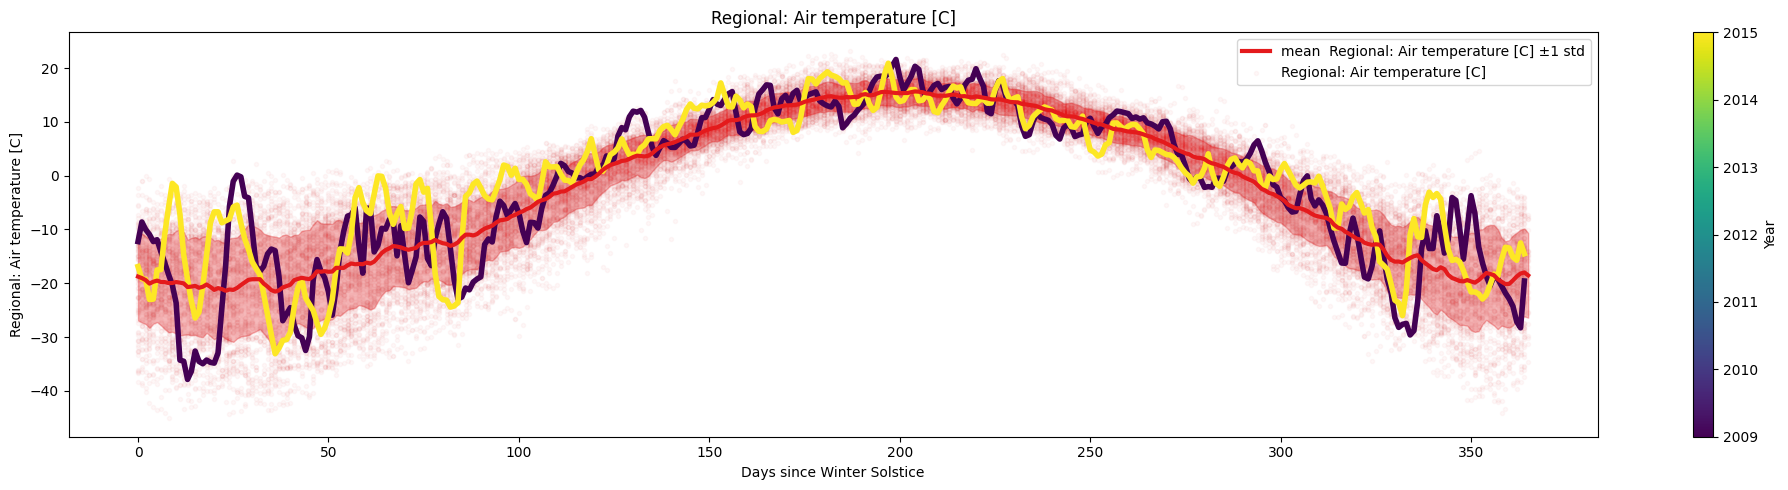

In [7]:
Data_2=days_since_last_date(Data,date='12/21',name='Winter Solstice')
ice.plot_contents(Data_2,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Winter Solstice',xaxis_name='Days since Winter Solstice',scatter_alpha=0.03,multiyear=selected_years)

## `groupby` and `transform`

So far we have grouped  variables using the number of days since the last occurrence of a date ('MM/DD'), but for more complex groupings it is convenient to use `groupby` and `transform` instead.

For example, lets try to re-create the plot above but considering the 'number of days since the river began to freeze'  which happens at different dates each year.

> Let's define the event: `river has began to freeze` as the latest occasion( in the year) since the mean daily temperature was below zero for three consecutive days after it was above 0.


**Naive Approach**

A simple approach would be to loop through each year and day checking if the river has started to freeze.
<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4:</b> 

Complete the missing line int the following code snippet, use the [`time`](https://docs.python.org/3/library/time.html#functions) module to estimate the time needed to execute the operation.

</p>




In [8]:
t1_0 = time.time()
years = Data.index.year.unique()
freezing_dates_1 = [None] * len(years)  

for year_index, year in enumerate(years):  # Looping through years 
    df_year = Data[Data.index.year == year].copy()  # Extracting data for that year
    df_year['Rolling Mean'] = df_year['Regional: Air temperature [C]'].rolling(window=3).mean()  # Compute rolling mean

    Frozen = False  # Initial state

    for i in range(3, len(df_year)):  # Looping through days of that year, starting from day 3 since we are using a rolling mean of 3
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']  
        T_rolling_mean = df_year.at[df_year.index[i], 'Rolling Mean']  
        T_rolling_mean_prev = df_year.at[df_year.index[i - 1], 'Rolling Mean']  
        
        if T_rolling_mean < 0 and T_rolling_mean_prev >= 0:  # Condition for freezing
            Frozen = True
            freezing_dates_1[year_index] = df_year.index[i].strftime('%Y/%m/%d')  

t1_f = time.time()  # Record the end time
delta_t1 = t1_f - t1_0
print(f"Elapsed time: {delta_t1:.4f} seconds")

Elapsed time: 1.3430 seconds


**Vector approach**

The method [`.groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) is used to *split* the dataframe into  groups based on some criteria, then the method [`.transform()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html) *applies* a function to the group.

Depending on the characteristics of the `DataFrame`/`Series` and the operation that you want to apply, similar methods such as `.filter()`, `. apply()`, `.agg()` or `.map()` might be more suitable (see [user guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)), 


In [9]:
t2_0 = time.time()
rolling_avg_below_zero = Data['Regional: Air temperature [C]'].rolling(window=3).mean().lt(0) # rolling mean '.ls'= less than and returns boolean
freezing_dates_2 = (
    rolling_avg_below_zero.groupby(Data.index.year)                                            # Group by year
    .apply(lambda x: x.index[x & ~x.shift(1, fill_value=False)].max())                         # logic to find the date and then keep the max date of each group(year)                       
    .dropna()                                                                                  # To avoid errors  in next line when the condition is not met
    .apply(lambda date: date.strftime('%Y/%m/%d'))                                             # Convert to string every element                                   
    .tolist()                                                                                  # Convert to list       
)
t2_f = time.time()  # Record the end time
delta_t2 = t2_f - t2_0
print(f"Elapsed time: {delta_t2:.4f} seconds")

Elapsed time: 0.0340 seconds


In the code above we did not use a function *per se*, instead we used a [`lambda`](https://docs.python.org/3/reference/expressions.html#grammar-token-python-grammar-lambda_expr) expression. Lambda expression are temporary and anonymous functions,  that allows us to evaluate a logical expression in a single line, without necessary defining the function . 

The vector approach is generally faster and more flexible as  multiple methods and expressions  can be efficiently apply to each group. However, it can be a little difficult to understand if you are not familiar with the syntax. The code above consist of 5 steps.

1. We create a `Series` with the freezing condition.  
    - `.rolling(window=3)` groups the data corresponding to three consecutive element. Because our index are dates, we are grouping the date of three consecutive days
    - `.mean()` computes the mean of the grouped data
    - `.lt(0)`  decide if the mean of the grouped is  less than (lt) 0. This logical expression output a boolean 
2. Grouping the data
    - `.groupby(Data.index.year)` groups the element of the `Series` according to the year in Data
    - `.index.year` extracts the year attribute of the datetime index to use the year of each row to group the data
3. Identifies when the freezing condition changes
    - `apply(lambda x: )`:  defines that we will use a `lambda` expression with `x`the variable
    - `x & ~x.shift(1, fill_value=False)`  Use the logical operator AND (`&`) to compare the variable with the  negated (`~`) shifted variable. 
    - `x.shift(1, fill_value=False)`shift the variable by one position, and assigning `False` to the first position.
4. Identifies the latest instance of change of freezing condition in each year 
    - `x.index[]` get the date associated with the change of freezing conditions
    - `.max()` get the latest date in each year ( maximum value of the index in the group (the data is grouped by year))

5. Post Processing
    - `.dropna()` drop the empty values which correspond to years where the freezing condition never happened (in this parituclar case it correspond to year without  temperature data)
    -  `.apply(lambda date: date.strftime('%Y/%m/%d'))` format the datetime object to a string
    - `.tolist()` convert the `Series` to a list

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '1917/10/15', '1918/10/14', '1919/10/29', '1920/10/02', '1921/10/13', '1922/10/19', '1923/10/31', '1924/10/07', '1925/10/23', '1926/10/25', '1927/10/05', '1928/11/06', '1929/10/13', '1930/10/11', '1931/10/10', '1932/10/14', '1933/10/04', '1934/12/10', '1935/11/06', '1936/10/28', '1937/10/18', '1938/10/28', '1939/10/05', '1940/10/30', '1941/10/09', '1942/10/07', '1943/10/20', '1944/10/22', '1945/10/08', '1946/10/19', '1947/10/10', '1948/10/06', '1949/10/05', '1950/10/10', '1951/11/04', '1952/10/18', '1953/10/17', '1954/11/04', '1955/10/08', '1956/09/22', '1957/10/25', '1958/10/04', '1959/10/07', '1960/10/07', '1961/10/23', '1962/10/18', '1963/10/10', '1964/10/15', '1965/09/30', '1966/10/09', '1967/10/06', '1968/10/05', '1969/10/20', '1970/11/03', '1971/10/19', '1972/10/20', '1973/10/06', '1974/09/30', '1975/10/08', '1976/11/15', '1977/10/13', '1978/10/11', '1979/11/13', '1980/10/27', '1981/1

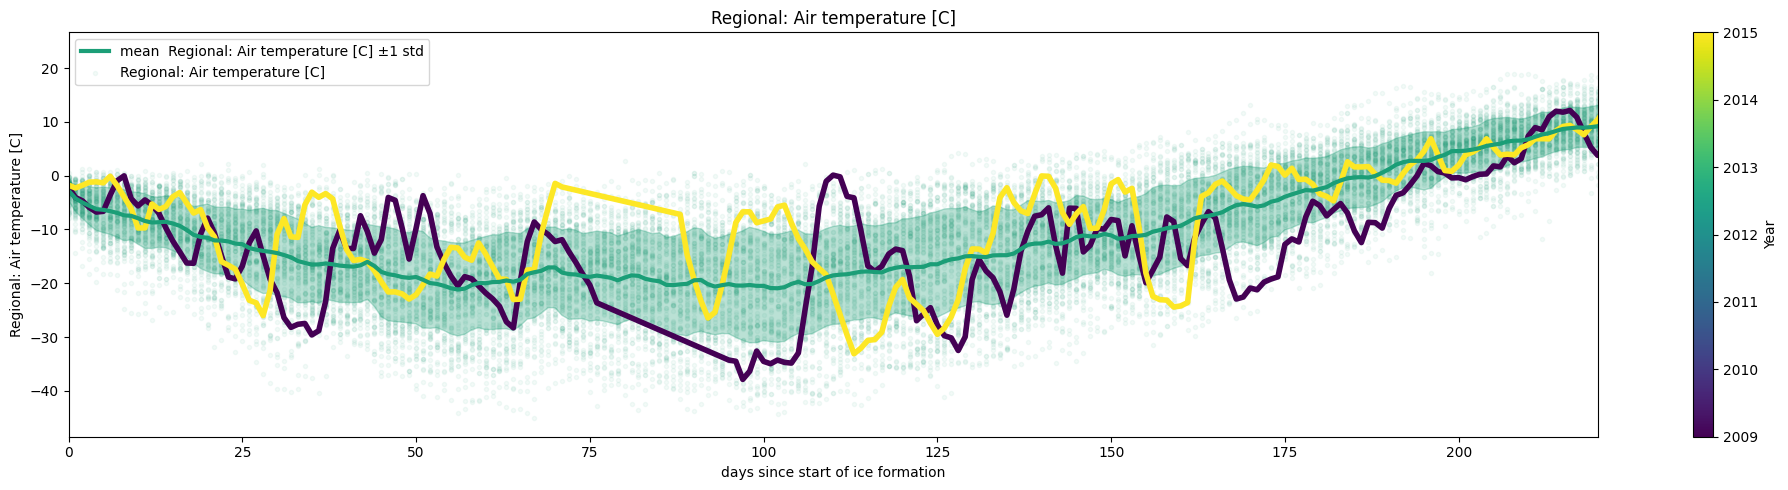

In [10]:
print(freezing_dates_1)
print(freezing_dates_2)
Data=days_since_last_date(Data,date=freezing_dates_2,name='days since start of ice formation')
ice.plot_contents(Data,plot_mean_std=True,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],
              xaxis='days since start of ice formation',scatter_alpha=0.05,col_cmap='Dark2',k=1,xlim=[0,220])

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 5:</b> 

Use `groupby()` and `transform()` to add a column with the accumulated number of days that the temperature has been over -2 degree.
And another column with the cumulative sum of the difference between the temperature and -2 [C], ignore the days that had negative temperature (i.e only days where the mean temperature was positive ( use masks(), clip() or use just logic))
</p>


In [11]:
Data['days_over_one'] = Data.groupby(Data.index.year)['Regional: Air temperature [C]'].transform(lambda x: (x > -2).cumsum()) # assumes that the number of day over 1 since the start of ice formation to jan 01 is zero 
Data['cumsum_pos_temp'] = Data.groupby(Data.index.year)['Regional: Air temperature [C]'].transform(lambda x: x.clip(lower=0).where(x > -2).cumsum())